In [204]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns

In [206]:
import pickle
df = pd.read_pickle('cleaned_df')

#df with price imputed (separate notebook)
lr_imputed_df = pd.read_pickle('lr_imputed_df')
med_imputed_df = pd.read_pickle('med_imputed_df')

In [207]:
lr_imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 2756
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   1309 non-null   object 
 1   Featured Price         1309 non-null   object 
 2   Category               1309 non-null   object 
 3   Page Name              1309 non-null   object 
 4   Tripadvisor Rating     1309 non-null   float64
 5   Address                1309 non-null   object 
 6   Property Amenities     1309 non-null   object 
 7   Room Features          1309 non-null   object 
 8   Room Types             1309 non-null   object 
 9   Hotel Style            1309 non-null   object 
 10  Languages              1309 non-null   object 
 11  Hotel Star Class       1309 non-null   object 
 12  Car/Walkability        1309 non-null   object 
 13  Restaurants Proximity  1309 non-null   object 
 14  Attractions Proximity  1309 non-null   object 
 15  Numb

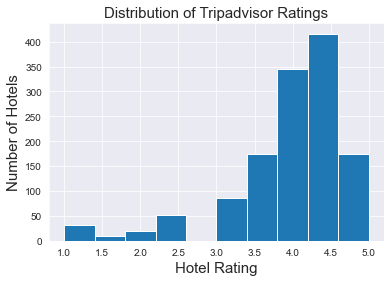

In [385]:
plt.hist(df['Tripadvisor Rating'])
plt.xlabel("Hotel Rating", fontsize = 15)
plt.ylabel("Number of Hotels", fontsize = 15)
plt.title("Distribution of Tripadvisor Ratings", fontsize = 15)
plt.savefig("rating_hist.png", bbox_inches="tight", dpi=500)

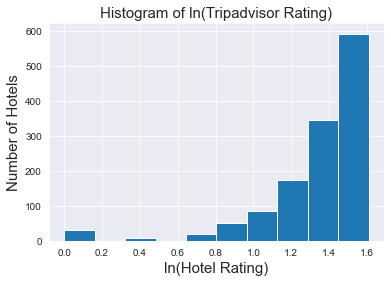

In [387]:
plt.hist(np.log(df['Tripadvisor Rating']))
plt.xlabel("ln(Hotel Rating)", fontsize = 15)
plt.ylabel("Number of Hotels", fontsize = 15)
plt.title("Histogram of ln(Tripadvisor Rating)", fontsize = 15)
plt.savefig("log_rating_hist.png", bbox_inches="tight", dpi=500)

In [ ]:
df['Tripadvisor Rating'].unique()

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.head()

In [208]:
smaller_df = df.loc[:,['Tripadvisor Rating', 'Hotel Style','Covid Precautions','Restaurants/Mile', 'Attractions/Mile','Property Amenities', 'Room Features']] 


### Exploring numerical data

In [209]:
even_smaller = smaller_df.loc[:,['Tripadvisor Rating', 'Restaurants/Mile', 'Attractions/Mile']]

In [210]:
even_smaller = even_smaller[(even_smaller['Restaurants/Mile'] != 'empty') & (even_smaller['Attractions/Mile'] != 'empty')]

In [211]:
even_smaller['Restaurants/Mile'] = even_smaller['Restaurants/Mile'].apply(lambda x: float(x))

In [212]:
even_smaller['Attractions/Mile'] = even_smaller['Attractions/Mile'].apply(lambda x: float(x))

In [213]:
even_smaller.head()

,Tripadvisor Rating,Restaurants/Mile,Attractions/Mile
0,4.5,73.33,10.00
2,4.5,103.33,16.67
4,4.5,110.00,16.67
6,4.5,133.33,13.33
10,3.5,153.33,23.33


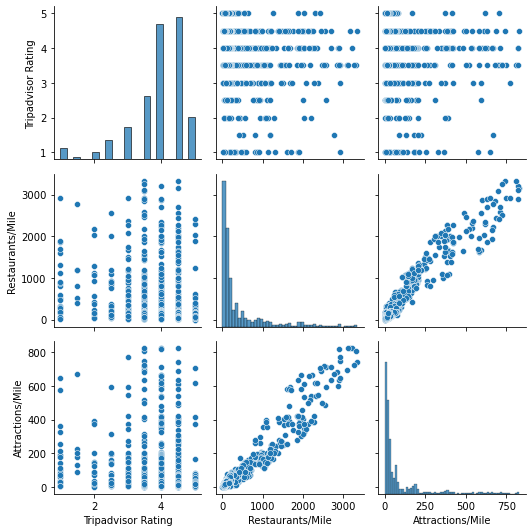

In [214]:
sns.pairplot(even_smaller)
plt.tight_layout()
plt.savefig('1_pairplot.png', dpi=300)

In [215]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [216]:
x = even_smaller.drop(columns=['Tripadvisor Rating'])
x = sm.add_constant(x)
y = even_smaller['Tripadvisor Rating']

/Users/zliao/opt/anaconda3/envs/metis/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [217]:
model = sm.OLS(y,x)
fit = model.fit()

vif = pd.DataFrame()
vif['variables'] = x.columns
vif['vif'] =[variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif

,variables,vif
0,const,1.496783
1,Restaurants/Mile,13.961696
2,Attractions/Mile,13.961696


VIFs are very high for Restaurants/Mile and Attractions/Mile..they are the same! Will just go with Attractions/Mile.

In [218]:
x = even_smaller.drop(columns=['Tripadvisor Rating', 'Restaurants/Mile'])
x = sm.add_constant(x)
y = even_smaller['Tripadvisor Rating']

/Users/zliao/opt/anaconda3/envs/metis/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [219]:

model = sm.OLS(y,x)
fit = model.fit()

vif = pd.DataFrame()
vif['variables'] = x.columns
vif['vif'] =[variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif

,variables,vif
0,const,1.334975
1,Attractions/Mile,1.000000


### Starting to add in Categorical variables
Each Category may have 50+ possible options, so will trim down to most common 15 features and categorize rest as "Other".

In [220]:
style_df = smaller_df['Hotel Style'].to_frame()

In [221]:
even_smaller = even_smaller.merge(style_df, left_index = True, right_index = True).drop(columns=['Restaurants/Mile'])

In [222]:
even_smaller = even_smaller[even_smaller['Hotel Style'] != '[]']

In [223]:
even_smaller #637 rows now, down from >1000

,Tripadvisor Rating,Attractions/Mile,Hotel Style
0,4.5,10.00,"['Business', 'Family']"
2,4.5,16.67,['Mid-range']
4,4.5,16.67,"['Family', 'Centrally Located']"
6,4.5,13.33,"['Bay View', 'Great View']"
10,3.5,23.33,"['Mid-range', 'Centrally Located']"
...,...,...,...
2639,4.5,12.00,['Centrally Located']
2697,4.0,5.60,['Family']
2714,5.0,4.00,['Charming']
2723,5.0,16.67,"['Charming', 'Quaint']"


In [224]:
from ast import literal_eval
styles = smaller_df['Hotel Style'].apply(literal_eval).explode().value_counts()

In [225]:
other_styles = list(styles[styles < 10].index)
other_styles

['Marina View',
 'City View',
 'Luxury',
 'Historic Hotel',
 'Lagoon View',
 'Quirky Hotels',
 'Trendy',
 'Harbor View',
 'Residential Neighborhood',
 'Mountain View',
 'Value',
 'Boutique',
 'Lake View',
 'Classic']

In [226]:
def replace_other(li, others):
    new_li = []
    for i in li:
        if i in others:
            new_li.append('Other')
        else:
            new_li.append(i)
    return new_li       

In [227]:
even_smaller['Hotel Style'] = even_smaller['Hotel Style'].apply(literal_eval).apply(lambda x: replace_other(x, other_styles))

In [228]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

s = even_smaller['Hotel Style']
mlb = MultiLabelBinarizer()

style_dummies = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=even_smaller.index).drop(columns=['Centrally Located'])
#dropped a column ('Centrally Located') to avoid dummy variable trap

In [229]:
v1 = even_smaller.merge(style_dummies, left_index = True, right_index = True).drop(columns='Hotel Style')

In [230]:
import numpy as np
#want to look at MAE too as I make another model with different features, since no large residuals
def find_mae(actual, predicted):
    return np.mean(np.abs(actual-predicted))

In [231]:
#LR on version 1
X_df = v1.drop(columns = ['Tripadvisor Rating'])
y_df = v1['Tripadvisor Rating']

# Split into train, val, and test
X, X_test, y, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=28)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=28)

# Fit simple LR on training set
lr = LinearRegression()
lr.fit(X_train,y_train)
print('OLS')
print('Train: ', lr.score(X_train,y_train).round(3))
print('Val: ', lr.score(X_val,y_val).round(3))
print('Mean Absolute Error of Val: ', round(find_mae(y_val, lr.predict(X_val)), 3))

print('Feature coefficient results:\n')
for feature, coef in zip(X_train.columns, lr.coef_):
    print(feature, ':', f'{coef:.2f}') 


OLS
Train:  0.331
Val:  0.231
Mean Absolute Error of Val:  0.371
Feature coefficient results:

Attractions/Mile : -0.00
Bay View : 0.06
Budget : -0.47
Business : 0.28
Charming : 0.63
Family : 0.25
Family Resort : -0.18
Great View : 0.17
Green : 0.23
Hidden Gem : 0.51
Mid-range : 0.20
Modern : 0.34
Ocean View : 0.35
Other : 0.25
Park View : 0.17
Quaint : 0.77
Quiet : 0.24
River View : 0.31
Romantic : 0.26


In [232]:
X1 = sm.add_constant(X_train)
sm.OLS(y_train, X1).fit().summary()
#checking what the constant is-- this is reference for 'Centrally Located' hotel style

/Users/zliao/opt/anaconda3/envs/metis/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Tripadvisor Rating   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     9.402
Date:                Tue, 14 Dec 2021   Prob (F-statistic):           4.43e-22
Time:                        15:03:56   Log-Likelihood:                -253.70
No. Observations:                 381   AIC:                             547.4
Df Residuals:                     361   BIC:                             626.3
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.8296      0.069     55.725      0.000       3.694       3.965
Attractions/Mile    -0.0005      0.000     -2.842      0.005      -0.001      -0.000
Bay View             0.0581      0.126      0.461      0.645      -0.190       0.306
Budget              -0.4678      0.107     -4.359      0.000      -0.679      -0.257
Business             0.2759      0.114      2.419      0.016       0.052       0.500
Charming             0.6271      0.106      5.895      0.000       0.418       0.836
Family               0.2493      0.071      3.502      0.001       0.109       0.389
Family Resort       -0.1763      0.161     -1.092      0.275      -0.494       0.141
Great View           0.1701      0.069      2.452      0.015       0.034       0.307
Green                0.2271      0.156      1.452      0.147      -0.081       0.535
Hidden Gem           0.5050      0.206      2.456      0.015       0.101       0.909
Mid-range            0.1970      0.069      2.870      0.004       0.062       0.332
Modern               0.3387      0.081      4.195      0.000       0.180       0.497
Ocean View           0.3479      0.099      3.532      0.000       0.154       0.542
Other                0.2491      0.100      2.491      0.013       0.052       0.446
Park View            0.1705      0.153      1.117      0.265      -0.130       0.471
Quaint               0.7697      0.250      3.080      0.002       0.278       1.261
Quiet                0.2381      0.157      1.512      0.131      -0.072       0.548
River View           0.3061      0.127      2.411      0.016       0.056       0.556
Romantic             0.2567      0.195      1.316      0.189      -0.127       0.640
==============================================================================
Omnibus:                       30.019   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.327
Skew:                          -0.584   Prob(JB):                     1.06e-09
Kurtosis:                       4.113   Cond. No.                     1.92e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [233]:
v1.corr()

,Tripadvisor Rating,Attractions/Mile,Bay View,Budget,Business,Charming,Family,Family Resort,Great View,Green,Hidden Gem,Mid-range,Modern,Ocean View,Other,Park View,Quaint,Quiet,River View,Romantic
Tripadvisor Rating,1.000000,-0.142879,-0.005294,-0.380375,0.033997,0.278287,0.024142,-0.052904,0.024118,0.057962,0.133644,0.052874,0.147761,0.044871,0.055453,0.005520,0.154148,0.017513,0.086306,0.121585
Attractions/Mile,-0.142879,1.000000,-0.052426,0.072745,0.153047,-0.101015,-0.046242,-0.067737,-0.135672,0.160214,-0.006385,0.028678,-0.023914,-0.104721,0.097642,-0.038237,-0.057653,0.031914,-0.046841,0.020630
Bay View,-0.005294,-0.052426,1.000000,-0.061898,-0.049314,-0.065258,-0.095802,-0.034418,0.135897,-0.038605,-0.028424,-0.102631,-0.085280,0.083847,0.013267,0.009649,-0.027079,-0.038605,-0.039590,-0.035506
Budget,-0.380375,0.072745,-0.061898,1.000000,-0.066391,-0.087856,-0.097342,-0.046337,-0.158813,-0.051973,-0.038266,-0.162305,-0.080500,-0.082409,-0.069857,-0.049227,-0.036457,-0.051973,-0.053300,-0.047801
Business,0.033997,0.153047,-0.049314,-0.066391,1.000000,-0.069994,-0.044864,-0.036916,-0.092489,0.123443,-0.030486,-0.011541,-0.007754,-0.065654,0.003439,0.090896,-0.029044,-0.041407,-0.002212,-0.038083
Charming,0.278287,-0.101015,-0.065258,-0.087856,-0.069994,1.000000,-0.105713,-0.048851,-0.154087,-0.022476,0.046184,-0.065571,-0.071807,-0.065530,0.003317,-0.051898,0.097583,-0.022476,0.038503,0.124451
Family,0.024142,-0.046242,-0.095802,-0.097342,-0.044864,-0.105713,1.000000,0.036027,-0.136014,-0.056271,-0.059226,0.015195,-0.067229,-0.079641,-0.125298,0.000120,-0.056425,-0.032101,-0.035281,-0.073983
Family Resort,-0.052904,-0.067737,-0.034418,-0.046337,-0.036916,-0.048851,0.036027,1.000000,-0.017042,0.028628,-0.021278,-0.066764,-0.063840,-0.045822,-0.015173,-0.027372,-0.020271,0.028628,-0.029637,-0.026579
Great View,0.024118,-0.135672,0.135897,-0.158813,-0.092489,-0.154087,-0.136014,-0.017042,1.000000,-0.056418,-0.072927,-0.187495,-0.099733,0.110515,-0.081305,-0.026517,-0.069477,-0.035102,0.044154,-0.044969
Green,0.057962,0.160214,-0.038605,-0.051973,0.123443,-0.022476,-0.056271,0.028628,-0.056418,1.000000,-0.023866,-0.038010,-0.045392,-0.017293,0.006634,-0.030702,-0.022737,-0.032415,-0.033242,-0.029813


In [234]:
#just double checking if correlation btwn these; shouldn't be
vif = pd.DataFrame()
vif['variables'] = X_train.columns
vif['vif'] =[variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif

,variables,vif
0,Attractions/Mile,1.286268
1,Bay View,1.092621
2,Budget,1.042015
3,Business,1.159392
4,Charming,1.145858
5,Family,1.142157
6,Family Resort,1.038286
7,Great View,1.165040
8,Green,1.102062
9,Hidden Gem,1.063872


In [369]:
#LR on version 1 - this time taking log of target
import numpy as np
X_df = v1.drop(columns = ['Tripadvisor Rating'])
y_df = np.log(v1['Tripadvisor Rating'])

# Split into train, val, and test
X, X_test, y, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=28)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=28)

# Fit
lr = LinearRegression()
lr.fit(X_train,y_train)
print('OLS')
print('Train: ', lr.score(X_train,y_train).round(3))
print('Val: ', lr.score(X_val,y_val).round(3))
print('Mean Absolute Error of Val: ', round(find_mae(y_val, lr.predict(X_val)), 3))

OLS
Train:  0.322
Val:  0.238
Mean Absolute Error of Val:  0.095


Let's start doing diagnostic plotting for assumptions

In [236]:
import scipy.stats as stats

def diagnostic_plot(y_predict, y_actual):
    plt.figure(figsize=(20,5))
    
    #rgr = LinearRegression()
    #rgr.fit(x,y)
    #pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(y_predict,y_actual)
    plt.plot(y_actual, y_actual, color='blue',linewidth=1)
    plt.title("Model fit")
    plt.xlabel("Predicted target values")
    plt.ylabel("Actual target values")
    
    plt.subplot(1, 3, 2)
    res = y_actual - y_predict
    plt.scatter(y_predict, res)
    plt.title("Residual plot")
    plt.xlabel("Prediction")
    plt.ylabel("Residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    #trying to see if residual distribution is normal
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

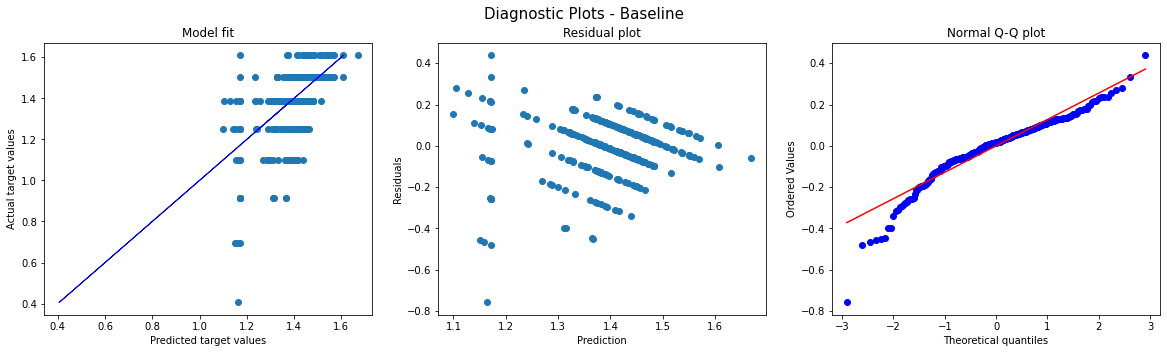

In [237]:
diagnostic_plot(lr.predict(X_train), y_train)
plt.suptitle("Diagnostic Plots - Baseline", fontsize = 15)
plt.savefig("diagnostic baseline", bbox_inches="tight", dpi=500)

(array([  1.,   0.,   0.,   0.,   3.,   0.,   8.,  19.,  47., 303.]),
 array([-1.1408938 , -0.98445402, -0.82801424, -0.67157447, -0.51513469,
        -0.35869491, -0.20225514, -0.04581536,  0.11062441,  0.26706419,
         0.42350397]),
 <BarContainer object of 10 artists>)

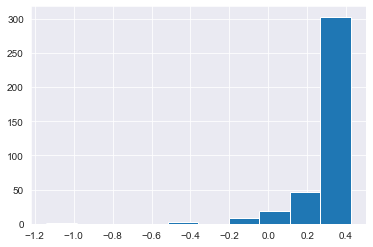

In [374]:
plt.hist(stats.boxcox((y_train), lmbda=0)) #same as log

(array([  1.,   0.,   0.,   3.,   0.,   8.,   0.,  19., 185., 165.]),
 array([-0.90272046, -0.76485991, -0.62699937, -0.48913882, -0.35127828,
        -0.21341773, -0.07555719,  0.06230336,  0.20016391,  0.33802445,
         0.475885  ]),
 <BarContainer object of 10 artists>)

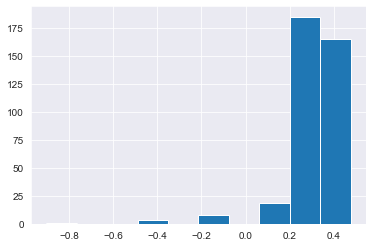

In [372]:
plt.hist(np.log(y_train))

(array([  1.,   0.,   3.,   0.,   8.,  19.,   0.,  47., 138., 165.]),
 array([0.40546511, 0.52586239, 0.64625967, 0.76665695, 0.88705423,
        1.00745151, 1.12784879, 1.24824607, 1.36864335, 1.48904063,
        1.60943791]),
 <BarContainer object of 10 artists>)

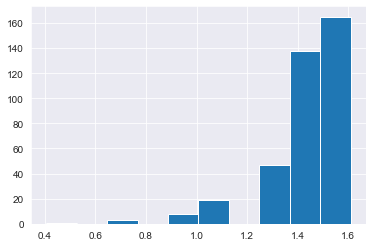

In [371]:
plt.hist(y_train)

Continue expanding on model

In [240]:
covid_df = smaller_df['Covid Precautions'].to_frame()

In [241]:
#adding if covid precautions y/n
v2 = v1.merge(covid_df, left_index=True, right_index=True)

In [242]:
v2['Covid Precautions Y/N'] = v2['Covid Precautions'].apply(lambda x: 0 if x == '[]' else 1)

In [243]:
v2.head()

,Tripadvisor Rating,Attractions/Mile,Bay View,Budget,Business,Charming,Family,Family Resort,Great View,Green,...,Modern,Ocean View,Other,Park View,Quaint,Quiet,River View,Romantic,Covid Precautions,Covid Precautions Y/N
0,4.5,10.00,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,['All linens sanitized in high-temperature was...,1
2,4.5,16.67,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,['Hand sanitizer available to guests & staff'],1
4,4.5,16.67,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,[],0
6,4.5,13.33,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,[],0
10,3.5,23.33,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,[],0


In [244]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def split_and_cross_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    # perform train/val split
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=28)
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 12)

    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train_val, y_train_val)
    
    # score fit model on validation data & report results
    print('\nCross Validation Scores:', cross_val_score(lr_model, X_train_val, y_train_val, cv=kf, scoring='r2'))
    print('\nMean R^2 Score:',np.mean(cross_val_score(lr_model, X_train_val, y_train_val, cv=kf, scoring='r2')))
    print('\nMean NMAE:', np.mean(cross_val_score(lr_model, X_train_val, y_train_val, cv=kf, scoring= 'neg_mean_absolute_error')))
    


In [245]:
#using this cv code on model v1
split_and_cross_validate(X_df, y_df)


Cross Validation Scores: [0.10500675 0.09333694 0.25601046 0.33685003 0.37606224]

Mean R^2 Score: 0.2334532847243605

Mean NMAE: -0.09692537775602873


In [246]:
#v2
split_and_cross_validate(v2.drop(columns=['Tripadvisor Rating', 'Covid Precautions']), v2['Tripadvisor Rating'])
#same 


Cross Validation Scores: [0.15141712 0.15752056 0.24527708 0.35290986 0.37649234]

Mean R^2 Score: 0.2567233911228231

Mean NMAE: -0.37116570615228034


In [250]:
#adding in price and number of reviews 
more_numericals = lr_imputed_df[['Featured Price','Number of Reviews', 'Hotel Star Class']]

In [251]:
more_numericals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 2756
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Featured Price     1309 non-null   object
 1   Number of Reviews  1309 non-null   int64 
 2   Hotel Star Class   1309 non-null   object
dtypes: int64(1), object(2)
memory usage: 40.9+ KB


In [252]:
more_numericals['Featured Price'] = more_numericals['Featured Price'].apply(lambda x: float(x))
more_numericals = more_numericals[more_numericals['Hotel Star Class'] != 'empty']
more_numericals['Hotel Star Class'] = more_numericals['Hotel Star Class'].apply(lambda x: float(x))

/var/folders/__/04d0437x46368yx2gw6qf2km0000gn/T/ipykernel_2484/1964471764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  more_numericals['Featured Price'] = more_numericals['Featured Price'].apply(lambda x: float(x))


In [253]:
v3 = v2.merge(more_numericals, left_index=True, right_index=True)

In [254]:
v3.head()

,Tripadvisor Rating,Attractions/Mile,Bay View,Budget,Business,Charming,Family,Family Resort,Great View,Green,...,Park View,Quaint,Quiet,River View,Romantic,Covid Precautions,Covid Precautions Y/N,Featured Price,Number of Reviews,Hotel Star Class
0,4.5,10.00,0,0,1,0,1,0,0,0,...,0,0,0,0,0,['All linens sanitized in high-temperature was...,1,84.0,373,3.5
2,4.5,16.67,0,0,0,0,0,0,0,0,...,0,0,0,0,0,['Hand sanitizer available to guests & staff'],1,123.0,541,3.0
4,4.5,16.67,0,0,0,0,1,0,0,0,...,0,0,0,0,0,[],0,106.0,369,3.0
6,4.5,13.33,1,0,0,0,0,0,1,0,...,0,0,0,0,0,[],0,183.0,275,3.5
10,3.5,23.33,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[],0,85.0,207,3.0


In [255]:
split_and_cross_validate(v3.drop(columns=['Tripadvisor Rating', 'Covid Precautions']), v3['Tripadvisor Rating'])


Cross Validation Scores: [0.11383976 0.32745091 0.24678788 0.12034891 0.12001091]

Mean R^2 Score: 0.1856876732341536

Mean NMAE: -0.3565864800947674


In [256]:
others_2 = med_imputed_df[['Featured Price','Number of Reviews', 'Hotel Star Class']]
others_2['Featured Price'] = others_2['Featured Price'].apply(lambda x: float(x))
others_2 = others_2[others_2['Hotel Star Class'] != 'empty']
others_2['Hotel Star Class'] = others_2['Hotel Star Class'].apply(lambda x: float(x))

/var/folders/__/04d0437x46368yx2gw6qf2km0000gn/T/ipykernel_2484/1358770841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  others_2['Featured Price'] = others_2['Featured Price'].apply(lambda x: float(x))


In [257]:
#trying model with price included (imputed by median)
v4 = v2.merge(others_2, left_index=True, right_index=True)

In [258]:
split_and_cross_validate(v4.drop(columns=['Tripadvisor Rating', 'Covid Precautions']), v4['Tripadvisor Rating'])


Cross Validation Scores: [0.0507772  0.3057304  0.26003441 0.11260786 0.10511841]

Mean R^2 Score: 0.16685365886467884

Mean NMAE: -0.36009706214295456


In [259]:
vif = pd.DataFrame()
X_train = v4.drop(columns=['Tripadvisor Rating', 'Covid Precautions'])
vif = pd.DataFrame()
vif['variables'] = X_train.columns
vif['vif'] =[variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif
#high vif for featured price (for both median and LR imputed prices), hotel star class -- will address with regularization 

,variables,vif
0,Attractions/Mile,1.710877
1,Bay View,1.155771
2,Budget,1.198715
3,Business,1.200056
4,Charming,1.299775
5,Family,1.462989
6,Family Resort,1.123995
7,Great View,1.902399
8,Green,1.227569
9,Hidden Gem,1.088916


### Going to build off of V3 - add more dummy variables

In [260]:
property_amenities = smaller_df[smaller_df['Property Amenities'] != 'empty']['Property Amenities'].apply(literal_eval).explode().value_counts()

In [261]:
top_15_amenities = list(property_amenities.nlargest(15).index)
top_15_amenities

['Non-smoking hotel',
 'Free parking',
 'Wifi',
 'Pool',
 'Self-serve laundry',
 'Free High Speed Internet (WiFi)',
 'Outdoor pool',
 'Baggage storage',
 'BBQ facilities',
 'Laundry service',
 'Washing machine',
 'Parking',
 'Spa',
 'Children Activities (Kid / Family Friendly)',
 'Fitness Center with Gym / Workout Room']

In [262]:
other_amenities = [item for item in list(property_amenities.index) if item not in top_15_amenities]

In [263]:
smaller_df_v2 = smaller_df[smaller_df['Property Amenities'] != 'empty']

In [264]:
smaller_df_v2['Property Amenities'] = smaller_df_v2['Property Amenities'].apply(literal_eval).apply(lambda x: replace_other(x, other_amenities))

/var/folders/__/04d0437x46368yx2gw6qf2km0000gn/T/ipykernel_2484/2303710619.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smaller_df_v2['Property Amenities'] = smaller_df_v2['Property Amenities'].apply(literal_eval).apply(lambda x: replace_other(x, other_amenities))


In [265]:
#one-hot encoding 
s = smaller_df_v2['Property Amenities']
mlb = MultiLabelBinarizer()

property_dummies = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=smaller_df_v2.index).drop(columns=['Non-smoking hotel'])
#manually dropping 1 column - 'Non-smoking Hotel'

In [266]:
v3 = v3.drop(columns=['Covid Precautions'])
v5 = v3.merge(property_dummies, left_index = True, right_index = True)

In [267]:
split_and_cross_validate(v5.drop(columns=['Tripadvisor Rating']), v5['Tripadvisor Rating'])


Cross Validation Scores: [ 0.35546951  0.44724639  0.35011971  0.33784414 -0.1136179 ]

Mean R^2 Score: 0.27541237043622163

Mean NMAE: -0.347527097217546


In [268]:
#now adding Room Features

room_features = smaller_df[smaller_df['Room Features'] != 'empty']['Room Features'].apply(literal_eval).explode().value_counts()

In [269]:
top_15_features = list(room_features.nlargest(15).index)
top_15_features

['Refrigerator',
 'Air conditioning',
 'Kitchenette',
 'Flatscreen TV',
 'Microwave',
 'Iron',
 'Bath / shower',
 'Hair dryer',
 'Kitchenware',
 'Seating area',
 'Coffee / tea maker',
 'Private balcony',
 'Complimentary toiletries',
 'Dishwasher',
 'Wake-up service / alarm clock']

In [270]:
other_features = [item for item in list(room_features.index) if item not in top_15_features]

In [271]:
smaller_df_v2 = smaller_df[smaller_df['Room Features'] != 'empty']

In [272]:
smaller_df_v2['Room Features'] = smaller_df_v2['Room Features'].apply(literal_eval).apply(lambda x: replace_other(x, other_features))

/var/folders/__/04d0437x46368yx2gw6qf2km0000gn/T/ipykernel_2484/2358239540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smaller_df_v2['Room Features'] = smaller_df_v2['Room Features'].apply(literal_eval).apply(lambda x: replace_other(x, other_features))


In [273]:
#one-hot encoding 
s = smaller_df_v2['Room Features']
mlb = MultiLabelBinarizer()

room_dummies = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=smaller_df_v2.index).drop(columns=['Complimentary toiletries'])
#manually dropping 1 column - 'Complimentary toiletries'

In [274]:
v6 = v5.merge(room_dummies, left_index = True, right_index = True)

In [275]:
split_and_cross_validate(v6.drop(columns=['Tripadvisor Rating']), v6['Tripadvisor Rating'])


Cross Validation Scores: [0.07801569 0.30024641 0.26043839 0.28738792 0.15969542]

Mean R^2 Score: 0.21715676539228124

Mean NMAE: -0.348044073144924


In [276]:
v6.head()

,Tripadvisor Rating,Attractions/Mile,Bay View,Budget,Business,Charming,Family,Family Resort,Great View,Green,...,Hair dryer,Iron,Kitchenette,Kitchenware,Microwave,Other,Private balcony,Refrigerator,Seating area,Wake-up service / alarm clock
0,4.5,10.00,0,0,1,0,1,0,0,0,...,1,1,0,0,0,1,0,1,1,0
2,4.5,16.67,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,1,0,0
4,4.5,16.67,0,0,0,0,1,0,0,0,...,0,0,1,1,0,0,1,0,0,0
6,4.5,13.33,1,0,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
10,3.5,23.33,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,0,1,0,1


In [277]:
v6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 571 entries, 0 to 2725
Data columns (total 54 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Tripadvisor Rating                           571 non-null    float64
 1   Attractions/Mile                             571 non-null    float64
 2   Bay View                                     571 non-null    int64  
 3   Budget                                       571 non-null    int64  
 4   Business                                     571 non-null    int64  
 5   Charming                                     571 non-null    int64  
 6   Family                                       571 non-null    int64  
 7   Family Resort                                571 non-null    int64  
 8   Great View                                   571 non-null    int64  
 9   Green                                        571 non-null    int64  
 10  H

In [278]:
#taking a more in depth look at the coefficients
X_df = v6.drop(columns = ['Tripadvisor Rating'])
y_df = v6['Tripadvisor Rating']

# Split into train, val, and test
X, X_test, y, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=28)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=28)

X2 = sm.add_constant(X_train)
model = sm.OLS(y_train, X2)
model.fit().summary()

/Users/zliao/opt/anaconda3/envs/metis/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Tripadvisor Rating   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     4.798
Date:                Tue, 14 Dec 2021   Prob (F-statistic):           1.73e-18
Time:                        15:08:32   Log-Likelihood:                -153.81
No. Observations:                 342   AIC:                             415.6
Df Residuals:                     288   BIC:                             622.7
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                           3.3794      0.264     12.790      0.000       2.859       3.899
Attractions/Mile                            -6.712e-05      0.000     -0.353      0.724      -0.000       0.000
Bay View                                        0.0654      0.115      0.570      0.569      -0.160       0.291
Budget                                         -0.3150      0.123     -2.558      0.011      -0.557      -0.073
Business                                        0.1931      0.121      1.594      0.112      -0.045       0.432
Charming                                        0.3791      0.109      3.470      0.001       0.164       0.594
Family                                          0.1296      0.071      1.816      0.070      -0.011       0.270
Family Resort                                  -0.3426      0.161     -2.128      0.034      -0.659      -0.026
Great View                                      0.0905      0.070      1.293      0.197      -0.047       0.228
Green                                           0.3034      0.194      1.564      0.119      -0.078       0.685
Hidden Gem                                      0.4299      0.269      1.596      0.112      -0.100       0.960
Mid-range                                       0.0769      0.066      1.162      0.246      -0.053       0.207
Modern                                          0.3298      0.077      4.302      0.000       0.179       0.481
Ocean View                                      0.1065      0.092      1.161      0.247      -0.074       0.287
Other_x                                         0.2125      0.102      2.090      0.038       0.012       0.413
Park View                                       0.1598      0.169      0.944      0.346      -0.173       0.493
Quaint                                          0.3984      0.236      1.689      0.092      -0.066       0.863
Quiet                                           0.0857      0.125      0.686      0.493      -0.160       0.331
River View                                      0.2209      0.128      1.722      0.086      -0.032       0.473
Romantic                                        0.1822      0.154      1.186      0.237      -0.120       0.485
Covid Precautions Y/N                           0.2172      0.063      3.468      0.001       0.094       0.341
Featured Price                                  0.0010      0.000      2.272      0.024       0.000       0.002
Number of Reviews                            2.326e-05   2.08e-05      1.117      0.265   -1.77e-05    6.42e-05
Hotel Star Class                                0.0996      0.050      1.996      0.047       0.001       0.198
BBQ facilities                                  0.1642     

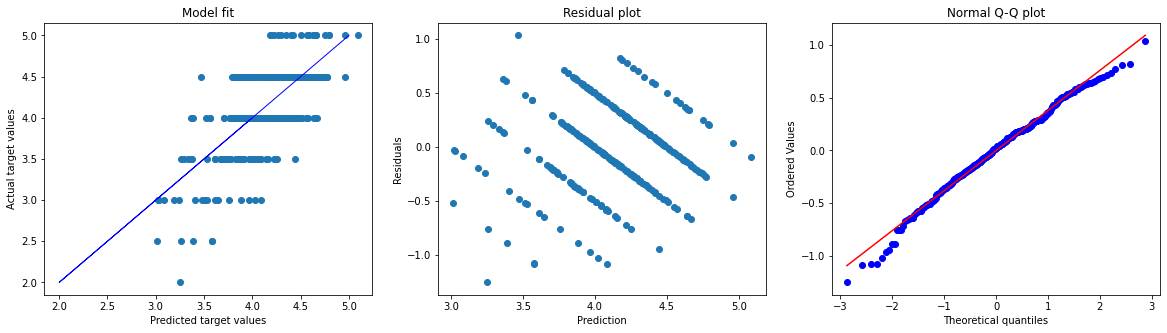

In [279]:

diagnostic_plot(model.fit().predict(X2), y_train)

## Regularization

Clean data first, by transforming numerical columns into percentiles (presented as between 0 and 1)


In [280]:
vif = pd.DataFrame()
X_train = v6.drop(columns=['Tripadvisor Rating'])
vif = pd.DataFrame()
vif['variables'] = X_train.columns
vif['vif'] =[variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif

,variables,vif
0,Attractions/Mile,2.358802
1,Bay View,1.274244
2,Budget,1.568349
3,Business,1.302804
4,Charming,1.413065
5,Family,1.602302
6,Family Resort,1.234553
7,Great View,2.094159
8,Green,1.331996
9,Hidden Gem,1.157456


In [420]:
#going to drop column Hotel Star Class so that other numerical columns can be percentiles
v_a = v6.drop(columns = ['Hotel Star Class'])

In [421]:
v_a #renamed to v_a just to preserve

,Tripadvisor Rating,Attractions/Mile,Bay View,Budget,Business,Charming,Family,Family Resort,Great View,Green,...,Hair dryer,Iron,Kitchenette,Kitchenware,Microwave,Other,Private balcony,Refrigerator,Seating area,Wake-up service / alarm clock
0,4.5,10.00,0,0,1,0,1,0,0,0,...,1,1,0,0,0,1,0,1,1,0
2,4.5,16.67,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,1,0,0
4,4.5,16.67,0,0,0,0,1,0,0,0,...,0,0,1,1,0,0,1,0,0,0
6,4.5,13.33,1,0,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
10,3.5,23.33,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2636,3.5,5.60,0,0,0,0,1,1,0,0,...,1,1,1,1,1,1,1,1,0,0
2639,4.5,12.00,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,0,1,1,0
2697,4.0,5.60,0,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,1,0,0
2723,5.0,16.67,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [422]:
#finding percentile then dividing by 100, to get value between 0-1
v_a['Attractions/Mi Percentile'] = v_a['Attractions/Mile'].apply(lambda x: stats.percentileofscore(v7['Attractions/Mile'], x)/ 100)

In [423]:
v_a[v_a['Attractions/Mi Percentile'] == v_a['Attractions/Mi Percentile'].min()] #min is 1.2 attractions/mile

,Tripadvisor Rating,Attractions/Mile,Bay View,Budget,Business,Charming,Family,Family Resort,Great View,Green,...,Iron,Kitchenette,Kitchenware,Microwave,Other,Private balcony,Refrigerator,Seating area,Wake-up service / alarm clock,Attractions/Mi Percentile
1114,5.0,1.2,0,0,0,0,0,0,1,0,...,0,0,0,1,1,0,1,0,0,0.001751


In [424]:
v_a[v_a['Attractions/Mi Percentile'] == v_a['Attractions/Mi Percentile'].max()] #100th percentile is ~827 attractions/mile

,Tripadvisor Rating,Attractions/Mile,Bay View,Budget,Business,Charming,Family,Family Resort,Great View,Green,...,Iron,Kitchenette,Kitchenware,Microwave,Other,Private balcony,Refrigerator,Seating area,Wake-up service / alarm clock,Attractions/Mi Percentile
1186,4.5,826.67,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1,1.0


In [425]:
#finding percentile then dividing by 100, to get value between 0-1
v_a['Featured Price Percentile'] = v_a['Featured Price'].apply(lambda x: stats.percentileofscore(v7['Featured Price'], x)/ 100)

In [426]:
v_a[v_a['Featured Price Percentile'] == v_a['Featured Price Percentile'].min()]['Featured Price'] #min is at $43/night

285    43.0
Name: Featured Price, dtype: float64

In [427]:
v_a[v_a['Featured Price Percentile'] ==v_a['Featured Price Percentile'].max()]['Featured Price'] #min is at $789/night

2027    789.0
Name: Featured Price, dtype: float64

In [428]:
#finding percentile then dividing by 100, to get value between 0-1
v_a['Num of Reviews Percentile'] = v_a['Number of Reviews'].apply(lambda x: stats.percentileofscore(v7['Number of Reviews'], x)/ 100)

In [429]:
v_a[v_a['Num of Reviews Percentile'] == v_a['Num of Reviews Percentile'].min()]['Number of Reviews'] #min is 1 review 

2127    1
2214    1
Name: Number of Reviews, dtype: int64

In [430]:
v_a[v_a['Num of Reviews Percentile'] == v_a['Num of Reviews Percentile'].max()] #max is 12697 reviews .. a lot!

,Tripadvisor Rating,Attractions/Mile,Bay View,Budget,Business,Charming,Family,Family Resort,Great View,Green,...,Kitchenware,Microwave,Other,Private balcony,Refrigerator,Seating area,Wake-up service / alarm clock,Attractions/Mi Percentile,Featured Price Percentile,Num of Reviews Percentile
84,4.5,76.67,0,0,0,0,0,0,1,0,...,1,1,1,1,1,1,1,0.744308,0.063047,1.0


In [431]:
#out of curiosity, it's this hotel
df[df['Number of Reviews'] == 12697]

,Name,Featured Price,Category,Page Name,Tripadvisor Rating,Address,Property Amenities,Room Features,Room Types,Hotel Style,...,Car/Walkability,Restaurants Proximity,Attractions Proximity,Number of Reviews,Covid Precautions,Travel Destination,Restaurants/Mile,Attractions/Mile,Zip Code,Walk Score
84,Meriton Suites Broadbeach,84.0,empty,Meriton Suites Broadbeach,4.5,"2669 Gold Coast Highway, Broadbeach, Gold Coas...","['Paid private parking on-site', 'Free High Sp...","['Blackout curtains', 'Soundproof rooms', 'Air...","['Mountain view', 'Ocean view', 'City view', '...","['Great View', 'Centrally Located']",...,100Great for walkersGrade: 100 out of 100,188 Restaurants within 0.3 miles,23 Attractions within 0.3 miles,12697,['All linens sanitized in high-temperature was...,Gold Coast,626.67,76.67,Queensland 4218 Australia,100


In [432]:
v7 = v_a.drop(columns=['Number of Reviews', 'Featured Price', 'Attractions/Mile'])

In [294]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression

from sklearn.model_selection import GridSearchCV

In [295]:

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [296]:
X_df = v7.drop(columns=['Tripadvisor Rating'])
y_df = v7['Tripadvisor Rating']

In [297]:
#More complete testing to compare lasso vs. ridge vs. elasticnet
# Split into train, val, and test
X, X_test, y, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=28)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=28)

In [367]:
v7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 571 entries, 0 to 2725
Data columns (total 53 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Tripadvisor Rating                           571 non-null    float64
 1   Bay View                                     571 non-null    int64  
 2   Budget                                       571 non-null    int64  
 3   Business                                     571 non-null    int64  
 4   Charming                                     571 non-null    int64  
 5   Family                                       571 non-null    int64  
 6   Family Resort                                571 non-null    int64  
 7   Great View                                   571 non-null    int64  
 8   Green                                        571 non-null    int64  
 9   Hidden Gem                                   571 non-null    int64  
 10  M

#### Lasso

In [298]:
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [299]:
lasso_model.alpha_

0.01

In [300]:
list(zip(X_train.columns, lasso_model.coef_))

[('Bay View', 0.0),
 ('Budget', -0.2454748400856759),
 ('Business', 0.0),
 ('Charming', 0.07917396967720078),
 ('Family', 0.042352705721174694),
 ('Family Resort', -0.0),
 ('Great View', 0.0),
 ('Green', 0.0),
 ('Hidden Gem', 0.0),
 ('Mid-range', -0.0),
 ('Modern', 0.14573713312916453),
 ('Ocean View', 0.0),
 ('Other_x', 0.0),
 ('Park View', 0.0),
 ('Quaint', 0.0),
 ('Quiet', 0.0),
 ('River View', 0.0),
 ('Romantic', 0.0),
 ('Covid Precautions Y/N', 0.18832627601470606),
 ('BBQ facilities', 0.08432240400784269),
 ('Baggage storage', -0.0),
 ('Children Activities (Kid / Family Friendly)', -0.0),
 ('Fitness Center with Gym / Workout Room', -0.057434966037976785),
 ('Free High Speed Internet (WiFi)', 0.15319649242836905),
 ('Free parking', 0.0),
 ('Laundry service', -0.03838767561249976),
 ('Other_y', 0.0),
 ('Outdoor pool', -0.0),
 ('Parking', -0.0),
 ('Pool', -0.015474460477237925),
 ('Self-serve laundry', 0.03441141692016594),
 ('Spa', -0.0),
 ('Washing machine', 0.0),
 ('Wifi', 0.1211

In [301]:
from sklearn.metrics import r2_score

#make predictions on validation set 
y_pred = lasso_model.predict(X_val)
# report results
print('\nCross Validation Scores:', cross_val_score(lasso_model, X_val, y_val, cv=kfold, scoring='r2'))
print('\nMean R^2 Score:',np.mean(cross_val_score(lasso_model, X_val, y_val, cv=kfold, scoring='r2')))
print('\nMean NMAE:', np.mean(cross_val_score(lasso_model, X_val, y_val, cv=kfold, scoring= 'neg_mean_absolute_error')))
    


#make predictions on train + val 
y_pred = lasso_model.predict(X)
#report results
print('\nCross Validation Scores:', cross_val_score(lasso_model, X, y, cv=kfold, scoring='r2'))
print('\nMean R^2 Score:',np.mean(cross_val_score(lasso_model, X, y, cv=kfold, scoring='r2')))
print('\nMean NMAE:', np.mean(cross_val_score(lasso_model, X, y, cv=kfold, scoring= 'neg_mean_absolute_error')))
    


Cross Validation Scores: [ 0.20983295  0.12401786  0.09840008 -0.31669069 -0.11468421]

Mean R^2 Score: 0.00017519606978824153

Mean NMAE: -0.339120273628276

Cross Validation Scores: [0.43534017 0.4328419  0.33180242 0.36523133 0.31173728]

Mean R^2 Score: 0.3753906206998721

Mean NMAE: -0.3053419094887221


### Ridge

In [302]:
alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [303]:
ridge_model.alpha_

6.222570836730231

In [304]:
list(zip(X_train.columns, ridge_model.coef_))

[('Bay View', 0.037174409298256064),
 ('Budget', -0.2787782062659034),
 ('Business', 0.10897406972916099),
 ('Charming', 0.19304907566691656),
 ('Family', 0.11801388245108026),
 ('Family Resort', -0.20574484520223102),
 ('Great View', 0.049014313472220725),
 ('Green', 0.09841984872232208),
 ('Hidden Gem', 0.08533178416403293),
 ('Mid-range', 0.024611964376697517),
 ('Modern', 0.22174297758648434),
 ('Ocean View', 0.04654724736392729),
 ('Other_x', 0.10211587236756628),
 ('Park View', 0.067031347213111),
 ('Quaint', 0.1339044000674326),
 ('Quiet', 0.02369206251667705),
 ('River View', 0.06526791334065447),
 ('Romantic', 0.09799441085610425),
 ('Covid Precautions Y/N', 0.20090348321518017),
 ('BBQ facilities', 0.14530223270060122),
 ('Baggage storage', -0.06959539117356732),
 ('Children Activities (Kid / Family Friendly)', -0.030830404364366057),
 ('Fitness Center with Gym / Workout Room', -0.09827581733552827),
 ('Free High Speed Internet (WiFi)', 0.15153570966954102),
 ('Free parking',

In [305]:
# score fit model on validation data & report results
y_pred = ridge_model.predict(X_val)
print('\nCross Validation Scores:', cross_val_score(ridge_model, X_val, y_val, cv=kfold, scoring='r2'))
print('\nMean R^2 Score:',np.mean(cross_val_score(ridge_model, X_val, y_val, cv=kfold, scoring='r2')))
print('\nMean NMAE:', np.mean(cross_val_score(ridge_model, X_val, y_val, cv=kfold, scoring= 'neg_mean_absolute_error')))
    


#make predictions on train + val 
y_pred = ridge_model.predict(X)
print('\nCross Validation Scores:', cross_val_score(ridge_model, X, y, cv=kfold, scoring='r2'))
print('\nMean R^2 Score:',np.mean(cross_val_score(ridge_model, X, y, cv=kfold, scoring='r2')))
print('\nMean NMAE:', np.mean(cross_val_score(ridge_model, X, y, cv=kfold, scoring= 'neg_mean_absolute_error')))
    


Cross Validation Scores: [ 0.10951239  0.14886426  0.03255906 -0.3021148  -0.32494683]

Mean R^2 Score: -0.06722518421611648

Mean NMAE: -0.3565199200273781

Cross Validation Scores: [0.43699845 0.47523389 0.34434109 0.34368773 0.35154357]

Mean R^2 Score: 0.3903609468869827

Mean NMAE: -0.30796516245288796


### Elastic Net

In [306]:
#elastic net

from sklearn.linear_model import ElasticNetCV
alphas = [0.0001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
l1_rats = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]

enet_model = ElasticNetCV(alphas = alphas, l1_ratio = l1_rats, cv = 5)
enet_model.fit(X_train, y_train)
print(enet_model.alpha_)
print(enet_model.l1_ratio_)

0.01
0.5


In [307]:
# score fit model on validation data & report results
y_pred = enet_model.predict(X_val)
print('\nCross Validation Scores:', cross_val_score(enet_model, X_val, y_val, cv=kfold, scoring='r2'))
print('\nMean R^2 Score:',np.mean(cross_val_score(enet_model, X_val, y_val, cv=kfold, scoring='r2')))
print('\nMean NMAE:', np.mean(cross_val_score(enet_model, X_val, y_val, cv=kfold, scoring= 'neg_mean_absolute_error')))
    


#make predictions on train + val 
y_pred = enet_model.predict(X)

# score fit model on validation data & report results
print('\nCross Validation Scores:', cross_val_score(enet_model, X, y, cv=kfold, scoring='r2'))
print('\nMean R^2 Score:',np.mean(cross_val_score(enet_model, X, y, cv=kfold, scoring='r2')))
print('\nMean NMAE:', np.mean(cross_val_score(enet_model, X, y, cv=kfold, scoring= 'neg_mean_absolute_error')))
    


Cross Validation Scores: [ 0.02812115  0.09604703  0.08208452 -0.60872916 -0.23965908]

Mean R^2 Score: -0.12842710812787855

Mean NMAE: -0.3637700718188729

Cross Validation Scores: [0.45979244 0.47279547 0.35593522 0.34167707 0.3546646 ]

Mean R^2 Score: 0.39697296178890695

Mean NMAE: -0.3045346738508924


In [308]:
list(zip(X_train.columns, enet_model.coef_))

[('Bay View', 0.0),
 ('Budget', -0.2922752939909409),
 ('Business', 0.016738568222523852),
 ('Charming', 0.13423552996531984),
 ('Family', 0.07781661202679148),
 ('Family Resort', -0.1269707330857652),
 ('Great View', 0.0),
 ('Green', 0.0),
 ('Hidden Gem', 0.0),
 ('Mid-range', -0.0),
 ('Modern', 0.17241574223873982),
 ('Ocean View', 0.0),
 ('Other_x', 0.022160584702824424),
 ('Park View', 0.0),
 ('Quaint', 0.0),
 ('Quiet', 0.0),
 ('River View', 0.0),
 ('Romantic', 0.0),
 ('Covid Precautions Y/N', 0.1972484216324537),
 ('BBQ facilities', 0.11285657111911471),
 ('Baggage storage', -0.01956797660485327),
 ('Children Activities (Kid / Family Friendly)', -0.013117136334160458),
 ('Fitness Center with Gym / Workout Room', -0.0728943175937109),
 ('Free High Speed Internet (WiFi)', 0.15294654323298196),
 ('Free parking', 0.0),
 ('Laundry service', -0.055969929788731776),
 ('Other_y', 0.0),
 ('Outdoor pool', -0.020400564023960524),
 ('Parking', 0.0),
 ('Pool', -0.03793709472821767),
 ('Self-ser

30 features, reduction of 42.31%


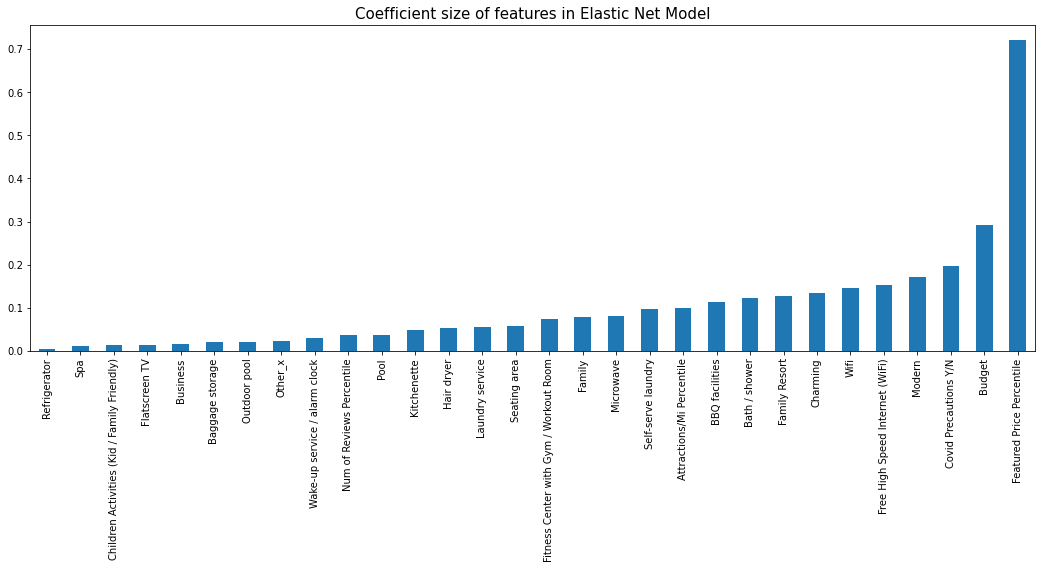

In [309]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(enet_model.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (18,6))

plt.title("Coefficient size of features in Elastic Net Model", fontsize = 15)
plt.savefig("enet_features_full.png", bbox_inches="tight", dpi=500)

## Reducing Features 
using Elastic Net results

In [310]:
v8 = v7.loc[:,['Tripadvisor Rating', 'Featured Price Percentile', 'Budget', 'Covid Precautions Y/N', 'Modern', 'Free High Speed Internet (WiFi)', 'Wifi', 'Charming', 'Family Resort', 'Bath / shower', 'BBQ facilities', 'Attractions/Mi Percentile']]



In [311]:
split_and_cross_validate(v8.drop(columns=['Tripadvisor Rating']), v8['Tripadvisor Rating'])
#reminder that this is score on train+val set


Cross Validation Scores: [0.4060252  0.40314171 0.38426889 0.49037389 0.36229983]

Mean R^2 Score: 0.4092219050218584

Mean NMAE: -0.30039491992563117


In [312]:
X_df = v8.drop(columns=['Tripadvisor Rating'])
y_df = v8['Tripadvisor Rating']

X, X_test, y, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=28)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=28)

In [313]:
vif = pd.DataFrame()
vif['variables'] = X_train.columns
vif['vif'] =[variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif

,variables,vif
0,Featured Price Percentile,3.434196
1,Budget,1.093291
2,Covid Precautions Y/N,1.511631
3,Modern,1.217260
4,Free High Speed Internet (WiFi),2.665640
5,Wifi,5.487131
6,Charming,1.175637
7,Family Resort,1.055295
8,Bath / shower,2.124561
9,BBQ facilities,2.515724


In [314]:
#getting rid of Wifi
v9 = v8.drop(columns=['Wifi'])

X_df = v9.drop(columns=['Tripadvisor Rating'])
y_df = v9['Tripadvisor Rating']

X, X_test, y, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=28)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=28)

In [315]:
vif = pd.DataFrame()
vif['variables'] = X_train.columns
vif['vif'] =[variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif

,variables,vif
0,Featured Price Percentile,3.174572
1,Budget,1.091437
2,Covid Precautions Y/N,1.476957
3,Modern,1.214410
4,Free High Speed Internet (WiFi),2.150485
5,Charming,1.174988
6,Family Resort,1.045668
7,Bath / shower,2.094514
8,BBQ facilities,2.501293
9,Attractions/Mi Percentile,2.662549


In [316]:
alphas = [0.0001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
l1_rats = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]

enet_model = ElasticNetCV(alphas = alphas, l1_ratio = l1_rats, cv = 5)
enet_model.fit(X_train, y_train)
print(enet_model.alpha_)
print(enet_model.l1_ratio_)

0.01
0.1


In [317]:
# score fit model on validation data & report results
y_pred = enet_model.predict(X_val)
print('\nCross Validation Scores:', cross_val_score(enet_model, X_val, y_val, cv=kfold, scoring='r2'))
print('\nMean R^2 Score:',np.mean(cross_val_score(enet_model, X_val, y_val, cv=kfold, scoring='r2')))
print('\nMean NMAE:', np.mean(cross_val_score(enet_model, X_val, y_val, cv=kfold, scoring= 'neg_mean_absolute_error')))
    

#make predictions on train + val 
y_pred = enet_model.predict(X)

# score fit model on validation data & report results
print('\nCross Validation Scores:', cross_val_score(enet_model, X, y, cv=kfold, scoring='r2'))
print('\nMean R^2 Score:',np.mean(cross_val_score(enet_model, X, y, cv=kfold, scoring='r2')))
print('\nMean NMAE:', np.mean(cross_val_score(enet_model, X, y, cv=kfold, scoring= 'neg_mean_absolute_error')))
    


Cross Validation Scores: [ 0.34777681  0.13510614  0.32165778 -0.33170129  0.11218851]

Mean R^2 Score: 0.1170055892021129

Mean NMAE: -0.3146325714102347

Cross Validation Scores: [0.45911983 0.46207591 0.36135495 0.33493184 0.34058877]

Mean R^2 Score: 0.39161425857237375

Mean NMAE: -0.3018534477457317


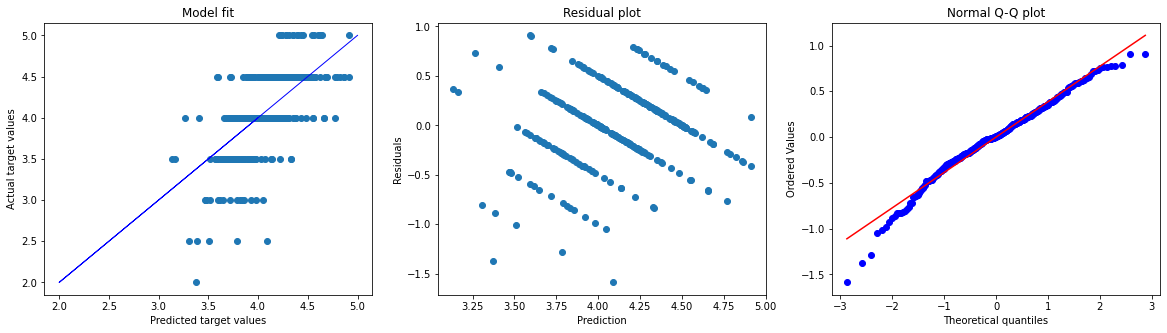

In [318]:
diagnostic_plot(enet_model.predict(X_train), y_train)

In [319]:
X_df = v9.drop(columns=['Tripadvisor Rating'])
y_df = v9['Tripadvisor Rating']

X, X_test, y, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=28)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=28)

Trying a few more transformations before deciding on final model

In [320]:
#log transform

X_df = v9.drop(columns=['Tripadvisor Rating'])
y_df_log = np.log(v9['Tripadvisor Rating'])

X, X_test, y, y_test = train_test_split(X_df, y_df_log, test_size=0.2, random_state=28)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=28)

In [321]:
split_and_cross_validate(X, y)


Cross Validation Scores: [0.28998281 0.39508492 0.55416432 0.39975608 0.25935454]

Mean R^2 Score: 0.3796685328045779

Mean NMAE: -0.07908014470774177


In [322]:
alphas = [0.0001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
l1_rats = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]

enet_model = ElasticNetCV(alphas = alphas, l1_ratio = l1_rats, cv = 5)
enet_model.fit(X_train, y_train)
print(enet_model.alpha_)
print(enet_model.l1_ratio_)

0.0001
0.1


In [324]:
# score fit model on validation data & report results
y_pred = enet_model.predict(X_val)
print('\nCross Validation Scores:', cross_val_score(enet_model, X_val, y_val, cv=kfold, scoring='r2'))
print('\nMean R^2 Score:',np.mean(cross_val_score(enet_model, X_val, y_val, cv=kfold, scoring='r2')))
print('\nMean NMAE:', np.mean(cross_val_score(enet_model, X_val, y_val, cv=kfold, scoring= 'neg_mean_absolute_error')))
    

#make predictions on train + val 
y_pred = enet_model.predict(X)
print('\nCross Validation Scores:', cross_val_score(enet_model, X, y, cv=kfold, scoring='r2'))
print('\nMean R^2 Score:',np.mean(cross_val_score(enet_model, X, y, cv=kfold, scoring='r2')))
print('\nMean NMAE:', np.mean(cross_val_score(enet_model, X, y, cv=kfold, scoring= 'neg_mean_absolute_error')))

#r^2 about same. NMAE looks to improve on first glance..but this is with log transformation! no longer on same scale, cannot compare in same rating units


Cross Validation Scores: [ 0.24504036  0.11348648  0.33627416 -0.45973062  0.08591321]

Mean R^2 Score: 0.06419671742278085

Mean NMAE: -0.07902909313645132

Cross Validation Scores: [0.45216661 0.47257516 0.3129442  0.31448901 0.34229076]

Mean R^2 Score: 0.37889314760594783

Mean NMAE: -0.07721446060802391


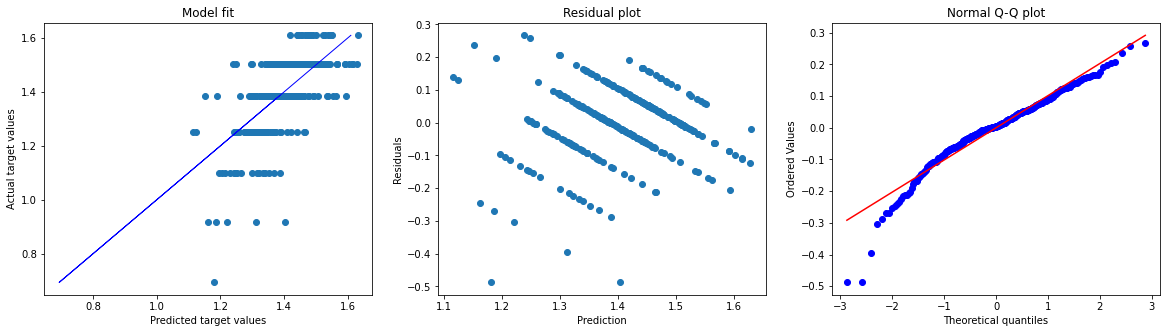

In [325]:
diagnostic_plot(enet_model.predict(X_train), y_train)

In [334]:
#trying polynomial features - hoping to identify useful interactions
#going to go off of v7, which had all the features

X_df_v7 = v7.drop(columns=['Tripadvisor Rating'])
y_df_v7 = v7['Tripadvisor Rating']

X, X_test, y, y_test = train_test_split(X_df_v7, y_df_v7, test_size=0.2, random_state=28)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=28)

from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2, interaction_only = True)
X_train_poly = poly.fit_transform(X_train)

# Apply polynomial transformation to val set
X_val_poly = poly.transform(X_val)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)
lr_poly.score(X_train_poly,y_train)

1.0

In [335]:
X_poly = poly.fit_transform(X)

split_and_cross_validate(X, y)


Cross Validation Scores: [0.29811893 0.33562172 0.28839655 0.26861928 0.23161617]

Mean R^2 Score: 0.284474529025032

Mean NMAE: -0.3416583347693969


In [336]:
pd.Series(index = poly.get_feature_names(), data = np.abs(lr_poly.coef_)).sort_values(ascending=False)

/Users/zliao/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


x50        0.345619
x26 x50    0.268747
x22 x25    0.239661
x12 x35    0.234614
x6 x36     0.232759
             ...   
x7 x16     0.000000
x8 x39     0.000000
x8 x11     0.000000
x8 x16     0.000000
x8 x35     0.000000
Length: 1379, dtype: float64

In [337]:
X_df_v7.info() #identifying which columns the top interactions are from

<class 'pandas.core.frame.DataFrame'>
Int64Index: 571 entries, 0 to 2725
Data columns (total 52 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Bay View                                     571 non-null    int64  
 1   Budget                                       571 non-null    int64  
 2   Business                                     571 non-null    int64  
 3   Charming                                     571 non-null    int64  
 4   Family                                       571 non-null    int64  
 5   Family Resort                                571 non-null    int64  
 6   Great View                                   571 non-null    int64  
 7   Green                                        571 non-null    int64  
 8   Hidden Gem                                   571 non-null    int64  
 9   Mid-range                                    571 non-null    int64  
 10  M

Based on own opinion on hotel factors/interpretability, the fitness center x laundry seems like good interaction to try. (columns 22 x 25)

In [339]:
#going off of v9 (with cut down features)
v10 = v9.merge(v7.loc[:,['Fitness Center with Gym / Workout Room', 'Laundry service']], left_index=True, right_index=True)

In [340]:
v10['Gym x Laundry'] = v10['Fitness Center with Gym / Workout Room'] * v10['Laundry service']

In [376]:
X_df = v10.drop(columns=['Tripadvisor Rating'])
y_df = v10['Tripadvisor Rating']

X, X_test, y, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=28)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=28)

In [377]:
split_and_cross_validate(X, y)


Cross Validation Scores: [0.28762636 0.44226952 0.52459752 0.4124905  0.25963234]

Mean R^2 Score: 0.3853232473995303

Mean NMAE: -0.30879240993292606


In [378]:
alphas = [0.0001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
l1_rats = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]

enet_model = ElasticNetCV(alphas = alphas, l1_ratio = l1_rats, cv = 5)
enet_model.fit(X_train, y_train)
print(enet_model.alpha_)
print(enet_model.l1_ratio_)

0.0001
0.1


In [379]:
# score fit model on validation data & report results
y_pred = enet_model.predict(X_val)
print('\nCross Validation Scores:', cross_val_score(enet_model, X_val, y_val, cv=kfold, scoring='r2'))
print('\nMean R^2 Score:',np.mean(cross_val_score(enet_model, X_val, y_val, cv=kfold, scoring='r2')))
print('\nMean NMAE:', np.mean(cross_val_score(enet_model, X_val, y_val, cv=kfold, scoring= 'neg_mean_absolute_error')))
    

#make predictions on train + val 
y_pred = enet_model.predict(X)

# score fit model on validation data & report results
print('\nCross Validation Scores:', cross_val_score(enet_model, X, y, cv=kfold, scoring='r2'))
print('\nMean R^2 Score:',np.mean(cross_val_score(enet_model, X, y, cv=kfold, scoring='r2')))
print('\nMean NMAE:', np.mean(cross_val_score(enet_model, X, y, cv=kfold, scoring= 'neg_mean_absolute_error')))


Cross Validation Scores: [ 0.34642479  0.13877094  0.28967129 -0.33170129  0.11438933]

Mean R^2 Score: 0.11151101309865044

Mean NMAE: -0.3148419533032987

Cross Validation Scores: [0.474697   0.46520567 0.33788406 0.3011819  0.35466618]

Mean R^2 Score: 0.38672696026364806

Mean NMAE: -0.3007125660089491


Adding the interaction term fitness x gym didn't make much of a difference (<0.01)

## Test

In [401]:
# testing on test set! going to go with v9

X_df = v9.drop(columns=['Tripadvisor Rating'])
y_df = v9['Tripadvisor Rating']

X, X_test, y, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=28)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=28)

In [402]:
alphas = [0.0001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
l1_rats = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]

enet_model = ElasticNetCV(alphas = alphas, l1_ratio = l1_rats, cv = 5)
enet_model.fit(X_train, y_train)
print(enet_model.alpha_)
print(enet_model.l1_ratio_)

0.01
0.1


In [403]:
enet_model.intercept_

3.6343294281183716

In [404]:
# score model on test set
test_pred = enet_model.predict(X_test)
print('\nCross Validation Scores:', cross_val_score(enet_model, X_test, y_test, cv=kfold, scoring='r2'))
print('\nMean R^2 Score:',np.mean(cross_val_score(enet_model, X_test, y_test, cv=kfold, scoring='r2')))
print('\nMean NMAE:', np.mean(cross_val_score(enet_model, X_test, y_test, cv=kfold, scoring= 'neg_mean_absolute_error')))
    


Cross Validation Scores: [0.39412421 0.2792942  0.30010608 0.4554698  0.38398331]

Mean R^2 Score: 0.36259551948319324

Mean NMAE: -0.31780537210813775


In [405]:
coefs = pd.Series(index = X_test.columns, data = enet_model.coef_).to_frame().reset_index()

In [406]:
coefs.rename(columns={'index': 'Features', 0: 'Coefficient'}, inplace=True)

In [407]:
coefs

,Features,Coefficient
0,Featured Price Percentile,0.673204
1,Budget,-0.313815
2,Covid Precautions Y/N,0.248415
3,Modern,0.202201
4,Free High Speed Internet (WiFi),0.193495
5,Charming,0.184140
6,Family Resort,-0.219948
7,Bath / shower,-0.084116
8,BBQ facilities,0.104946
9,Attractions/Mi Percentile,-0.114537


/var/folders/__/04d0437x46368yx2gw6qf2km0000gn/T/ipykernel_2484/2186288595.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels, size=15)


[Text(0, 0, 'Featured Price Percentile'),
 Text(1, 0, 'Budget'),
 Text(2, 0, 'Covid Precautions Y/N'),
 Text(3, 0, 'Modern'),
 Text(4, 0, 'Free High Speed Internet (WiFi)'),
 Text(5, 0, 'Charming'),
 Text(6, 0, 'Family Resort'),
 Text(7, 0, 'Bath / shower'),
 Text(8, 0, 'BBQ facilities'),
 Text(9, 0, 'Attractions/Mi Percentile')]

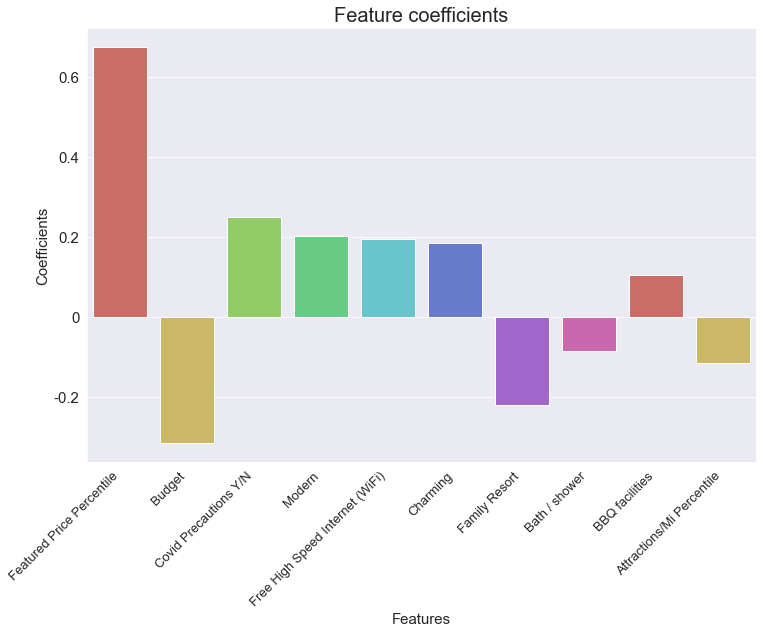

In [408]:
plt.figure(figsize = (12, 8))
sns.set_style("darkgrid")
g = sns.barplot(x='Features', y='Coefficient', data=coefs, palette= sns.color_palette("hls", 8))
plt.title("Feature coefficients", size = 20)
plt.xlabel('Features', size=15)
plt.ylabel('Coefficients', size=15)
#plt.xticks(rotation=90)
#g.set_yticklabels(g.get_yticks(), size = 10)
ylabels = [-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8]
g.set_yticklabels(ylabels, size=15)
g.set_xticks(range(len(coefs)))
_, xlabels = plt.xticks()
g.set_xticklabels(xlabels, size=13, horizontalalignment='right', rotation=45)

/Users/zliao/opt/anaconda3/envs/metis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


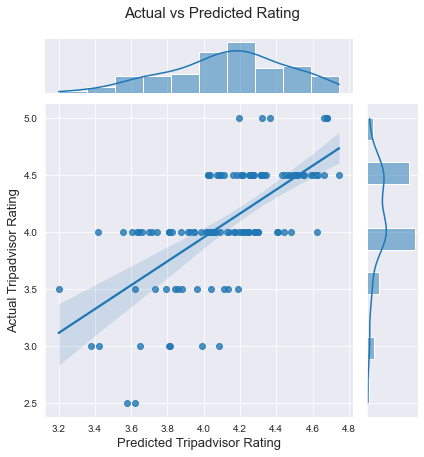

In [409]:
g1 = sns.jointplot(test_pred, y_test, kind='reg')
g1.set_axis_labels('Predicted Tripadvisor Rating', 'Actual Tripadvisor Rating', fontsize=13)
plt.tight_layout()
plt.suptitle("Actual vs Predicted Rating", y=1.05, fontsize=15)
plt.savefig("joint_actualvpredict.png", bbox_inches="tight", dpi=500)

/Users/zliao/opt/anaconda3/envs/metis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


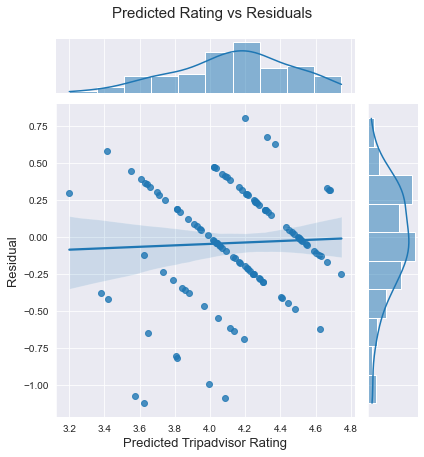

In [410]:
g2 = sns.jointplot(test_pred, (y_test - test_pred), kind='reg')
g2.set_axis_labels('Predicted Tripadvisor Rating', 'Residual', fontsize=13)
plt.tight_layout()
plt.suptitle("Predicted Rating vs Residuals", y=1.05, fontsize=15)
plt.savefig("joint_predictvresidual.png", bbox_inches="tight", dpi=500)

In [ ]:
v9.info()

In [388]:
v9.corr()

,Tripadvisor Rating,Featured Price Percentile,Budget,Covid Precautions Y/N,Modern,Free High Speed Internet (WiFi),Charming,Family Resort,Bath / shower,BBQ facilities,Attractions/Mi Percentile
Tripadvisor Rating,1.000000,0.494321,-0.322262,0.174691,0.154935,0.233960,0.261493,-0.070072,-0.020763,0.168917,-0.193919
Featured Price Percentile,0.494321,1.000000,-0.235886,-0.058318,0.068511,0.009692,0.181043,-0.022686,0.003284,0.168597,-0.235848
Budget,-0.322262,-0.235886,1.000000,-0.053187,-0.061218,-0.056860,-0.074027,-0.042607,-0.077982,-0.069154,0.049072
Covid Precautions Y/N,0.174691,-0.058318,-0.053187,1.000000,0.029272,0.001868,0.038866,0.065144,-0.045429,-0.176188,0.221662
Modern,0.154935,0.068511,-0.061218,0.029272,1.000000,0.059840,-0.074862,-0.065333,-0.019260,0.031555,0.022100
Free High Speed Internet (WiFi),0.233960,0.009692,-0.056860,0.001868,0.059840,1.000000,0.189608,-0.050687,0.087408,0.070764,-0.093323
Charming,0.261493,0.181043,-0.074027,0.038866,-0.074862,0.189608,1.000000,-0.046873,0.026693,0.016441,-0.127897
Family Resort,-0.070072,-0.022686,-0.042607,0.065144,-0.065333,-0.050687,-0.046873,1.000000,-0.036599,0.030076,-0.068558
Bath / shower,-0.020763,0.003284,-0.077982,-0.045429,-0.019260,0.087408,0.026693,-0.036599,1.000000,0.203867,-0.029070
BBQ facilities,0.168917,0.168597,-0.069154,-0.176188,0.031555,0.070764,0.016441,0.030076,0.203867,1.000000,-0.281065


In [395]:
v9['Tripadvisor Rating'].value_counts()

4.5    224
4.0    206
3.5     72
5.0     32
3.0     29
2.5      7
2.0      1
Name: Tripadvisor Rating, dtype: int64

In [396]:
np.median(v9['Tripadvisor Rating'])

4.0

In [397]:
np.mean(v9['Tripadvisor Rating'])

4.11646234676007

In [ ]:
intercept_

For interpretation, want to find median prices (50th percentile) for price and attractions/mile

In [433]:
np.median(v_a['Featured Price'])

155.77728622640336

In [435]:
np.median(v_a['Attractions/Mile'])

30.0